<center style='font-size:28px;'><u><b>Forecasts and Predictions</b></u></center>

1. [Project Description](#start)
    * [Data Description](#dd)
2. [Imports](#imp)
3. [EDA](#eda)
    * [Reading Data](#rda)
    * [Features grouped by churn](#fgbc)
    * [Correlation](#corr)
4. [Model](#model)
5. [User Clusters](#uscl)
    * [Dendrogram](#dend)
    * [Clustering](#clust)
    * [Feature Distribution per Cluster](#fdpclu)
    * [Churn per Cluster](#cpc)
6. [Conclusion](#conc)

# Project Description <a id="start"></a>

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.

For a gym, it makes sense to say a customer has left if they don't come for a month. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.

Project goal is to come up with a customer retention strategy:

- Predict the probability of churn (for the upcoming month) for each customer
- Draw up typical user portraits: select the most outstanding groups and describe their main features
- Analyse the factors that impact churn most
- Identify target groups
- Suggest measures to cut churn

## Description of The Data <a id="dd"></a>

**Gym_churn_us**

- Features

<ul><b>'gender'</b></ul>
<ul><b>'Near_Location'</b> - whether the user lives or works in the neighborhood where the gym is located</ul>
<ul><b>'Partner'</b> — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)</ul>
<ul><b>'Promo_friends'</b> — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)</ul>
<ul><b>'Phone'</b> — whether the user provided their phone number</ul>
<ul><b>'Age'</b></ul>
<ul><b>'Lifetime'</b> — the time (in months) since the customer first came to the gym</ul>
<ul><b>'Contract_period'</b> — 1 month, 3 months, 6 months, or 1 year</ul>
<ul><b>'Month_to_end_contract'</b> — the months remaining until the contract expires</ul>
<ul><b>'Group_visits'</b> — whether the user takes part in group sessions</ul>
<ul><b>'Avg_class_frequency_total'</b> — average frequency of visits per week over the customer's lifetime</ul>
<ul><b>'Avg_class_frequency_current_month'</b> — average frequency of visits per week over the preceding month</ul>
<ul><b>'Avg_additional_charges_total'</b> — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.</ul>

- Target

<ul><b>'Churn'</b> — the fact of churn for the month in question</ul>

# Imports <a id="imp"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
import warnings
warnings.filterwarnings("ignore")

# EDA <a id="eda"></a>

## Reading Data <a id="rda"></a>

In [4]:
try:
    gym_churn_us = pd.read_csv('gym_churn_us.csv')
except:
    gym_churn_us = pd.read_csv('/datasets/gym_churn_us.csv')

In [5]:
gym_churn_us.shape

(4000, 14)

In [6]:
gym_churn_us.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [7]:
gym_churn_us.Month_to_end_contract.value_counts()

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: Month_to_end_contract, dtype: int64

In [8]:
gym_churn_us.Month_to_end_contract = gym_churn_us.Month_to_end_contract.astype('int64')

In [9]:
gym_churn_us.Contract_period.value_counts()

1     2207
12     960
6      833
Name: Contract_period, dtype: int64

None of the customers signed for 3 months!

In [10]:
gym_churn_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int64  
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [11]:
gym_churn_us.duplicated().sum()

0

No missing values or duplicate records.

In [12]:
gym_churn_us.describe().loc['mean':'std']

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521


Both genders have about the same share out of all customers.
85% of customers are near-location.
49% of them work in a partner company.
31% of users originally signed up through a 'bring a friend' promo code.
Majority of users are around their late 20's.
The mean lifetime is about 4 months, and in them the average customer visits the gym about twice a week and spends around 150$ on additional gym-services.

Numbers not add up, as the mean of lifetime + mean of months to end contract is 8, suggesting the popular contract periods are 6 and 12 months. However, the mean contract period is 4.7. In all 3 latter features, std is about the same portion as the mean, and it might be the reason for this inconsistency.

Every month, about 26% of customers churn. Tough variance is high here as well.

## Features grouped by churn <a id="fgbc"></a>

In [13]:
gym_churn_us.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


There are some differences between the groups.

As can be expected, users who churn are living further away from the gym compared with no-churn customers. `Partner` and `Promo_friends` are also lower on churned users - maybe having co-workers and friends going with you to the gym helps in keeping this habbit alive. Accordingly, churned users are less prone to find themselves at gym's group sessions.

`Lifetime`'s mean significantly reduced for the churned users group, to only 1 month. That might explain the 25% lower additional charges for churned users. `Month_to_end_contract`'s mean drops as well to 1.5 month, suggesting churned users mostly sign up for the 1 month program, and indeed, the mean `Contract_period` for churned users is 1.7 months.

In average, churned users are 3 years younger, at 27.

For unchurned users (in the present month), no difference between average weekly visits for the recent month and the whole subscription period, while for churned users the average number of weekly visits is 25% lower, and even lower by another 25% for the last subscription month. It suggests churned users visit the gym relatively less, and stop coming to the gym some time before their subscription ends.

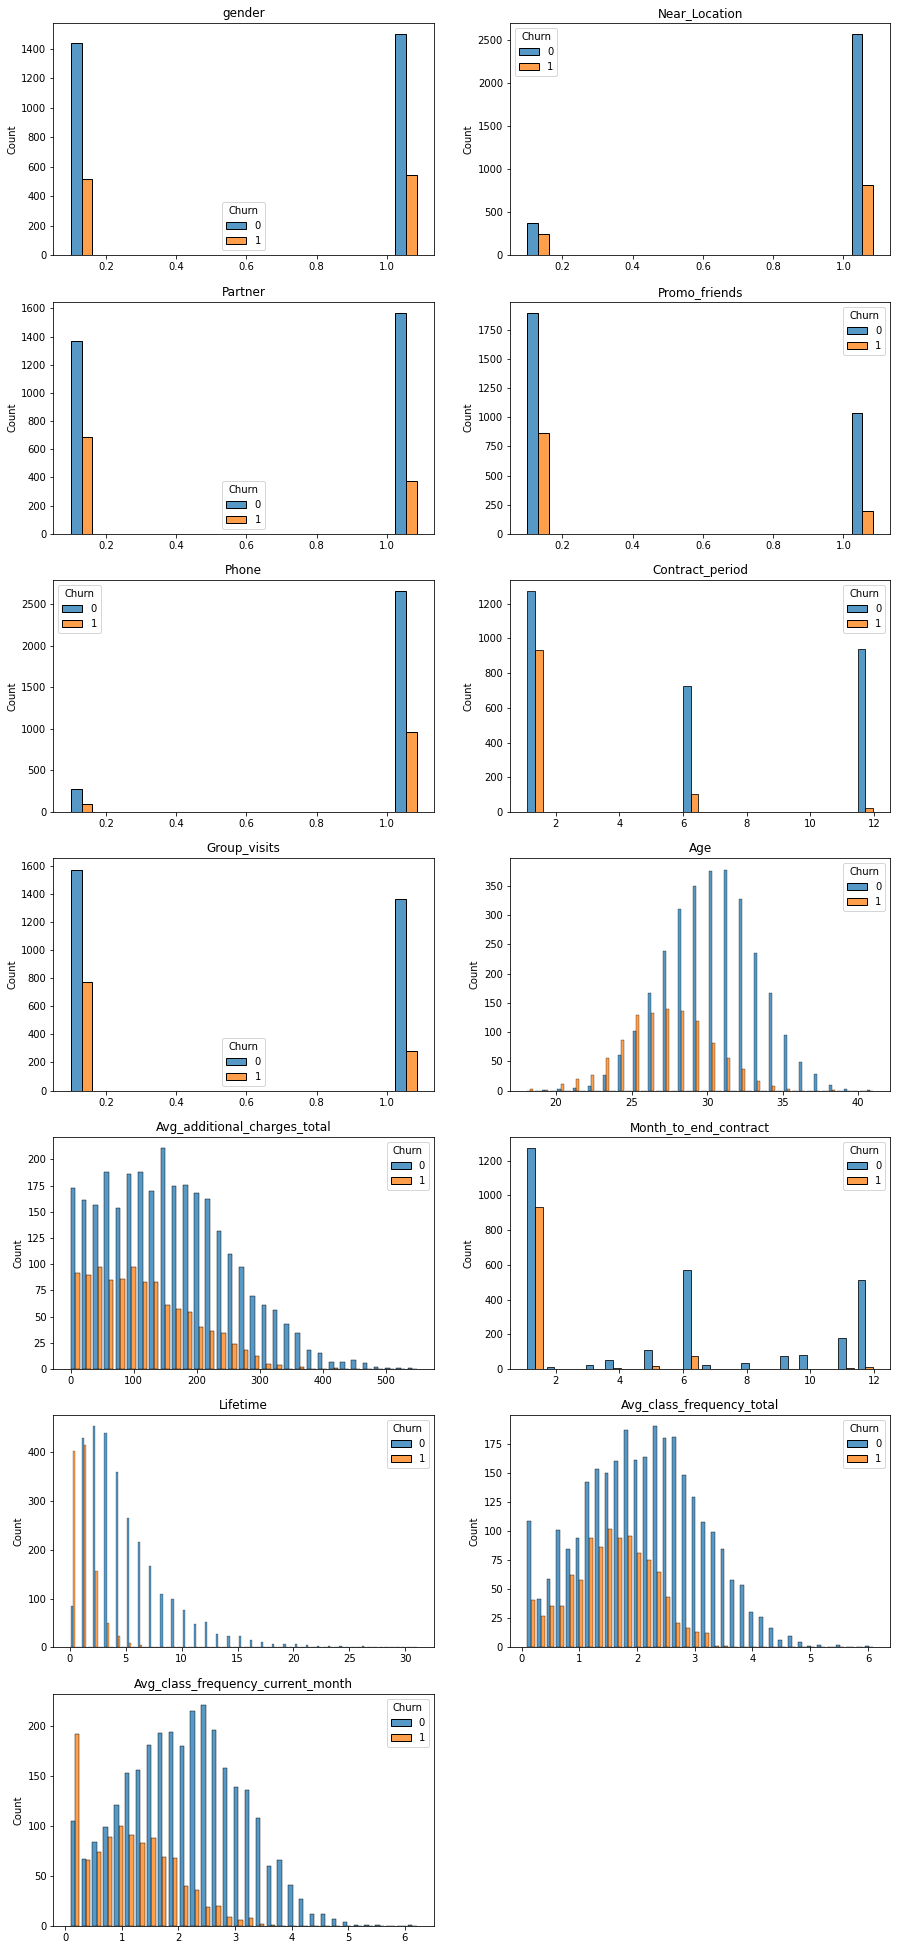

In [14]:
fig = plt.figure(figsize=(15,35))
cnt = 1
for i in gym_churn_us.drop('Churn',axis=1).columns:
    plt.subplot(7, 2, cnt)
    sns.histplot(data=gym_churn_us,x=i,hue='Churn',multiple="dodge", shrink=.8)
    plt.xlabel('')
    plt.title(i)
    cnt += 1
plt.show()

Both types have non-engaging users, with low values for additional charges, weekly visits, lifetime and program time. `Contract_period` for churned users is severly biased towards the 1 month program, and as a result lifetime and months to end of contract are biased the same on the churned case.

## Correlations <a id="corr"></a>

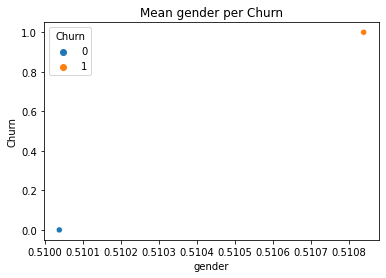

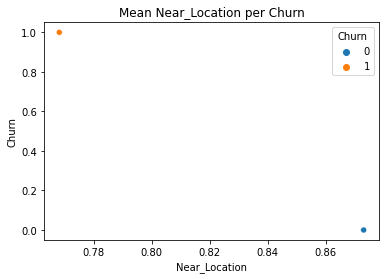

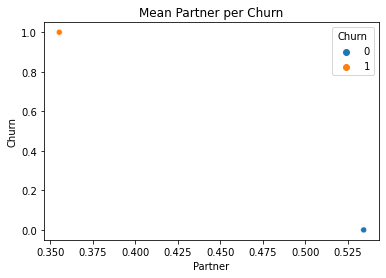

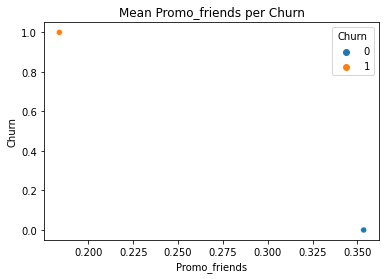

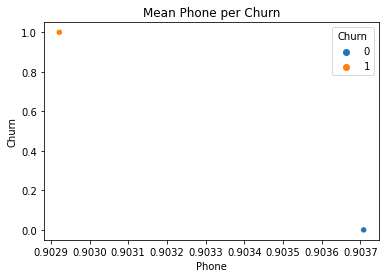

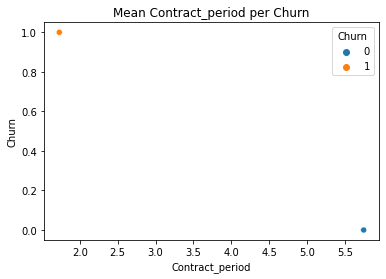

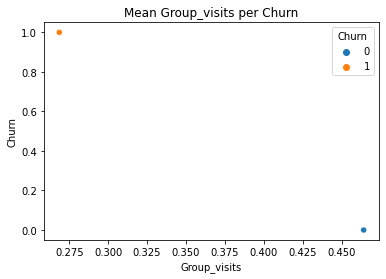

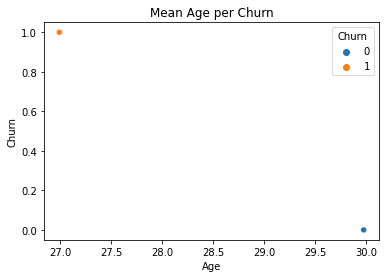

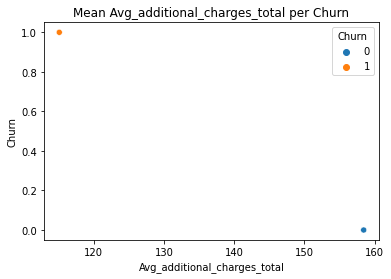

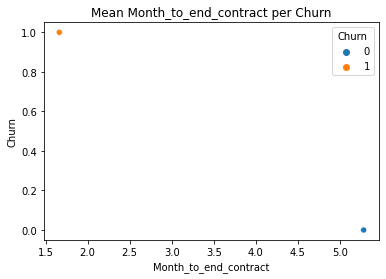

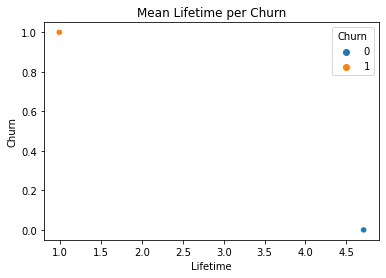

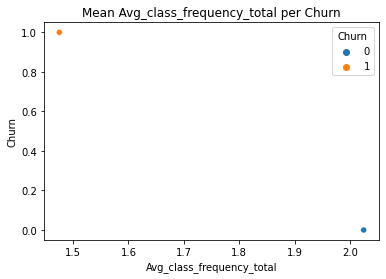

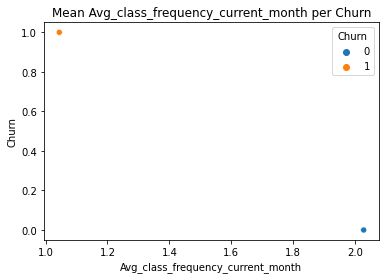

In [15]:
a = gym_churn_us.groupby('Churn').mean().reset_index()
for col in a.drop('Churn',axis=1):
    sns.scatterplot(data=a,x=col,y='Churn',hue='Churn')
    plt.title('Mean ' + col + ' per Churn')
    plt.show()

Location, partner, promos, contract period (along with month to end and lifetime), group visits, age, charges and weekly visits are all affected by churn the same - their average is lowered.

For numeric columns the distribution per churn is, in more detail, as follows:

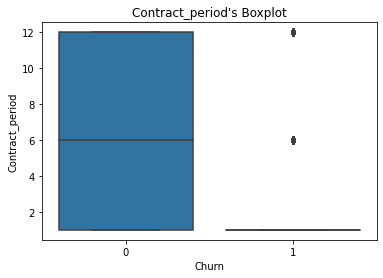

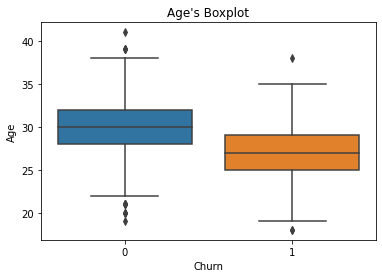

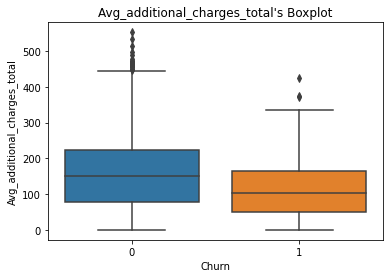

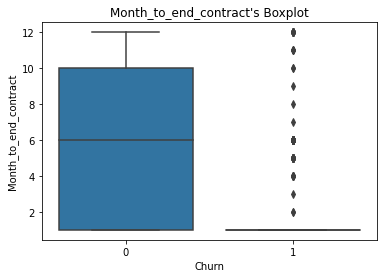

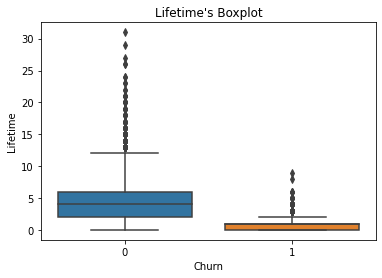

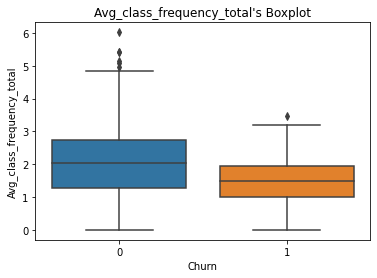

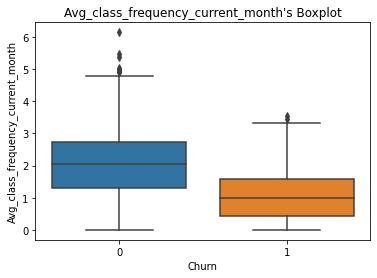

In [16]:
for col in gym_churn_us.drop(['Churn','gender','Near_Location','Partner','Promo_friends','Phone','Group_visits'],axis=1).columns:
    sns.boxplot(data=gym_churn_us, x='Churn',y=col)
    plt.title(col + "'s Boxplot")
    plt.show()

A `Contract_period` of 6 months is already an outlier for the churned users.
Small set of users had churned way before their contract was up.
For churned users, a lifetime of 3 months is already classified as an outlier.

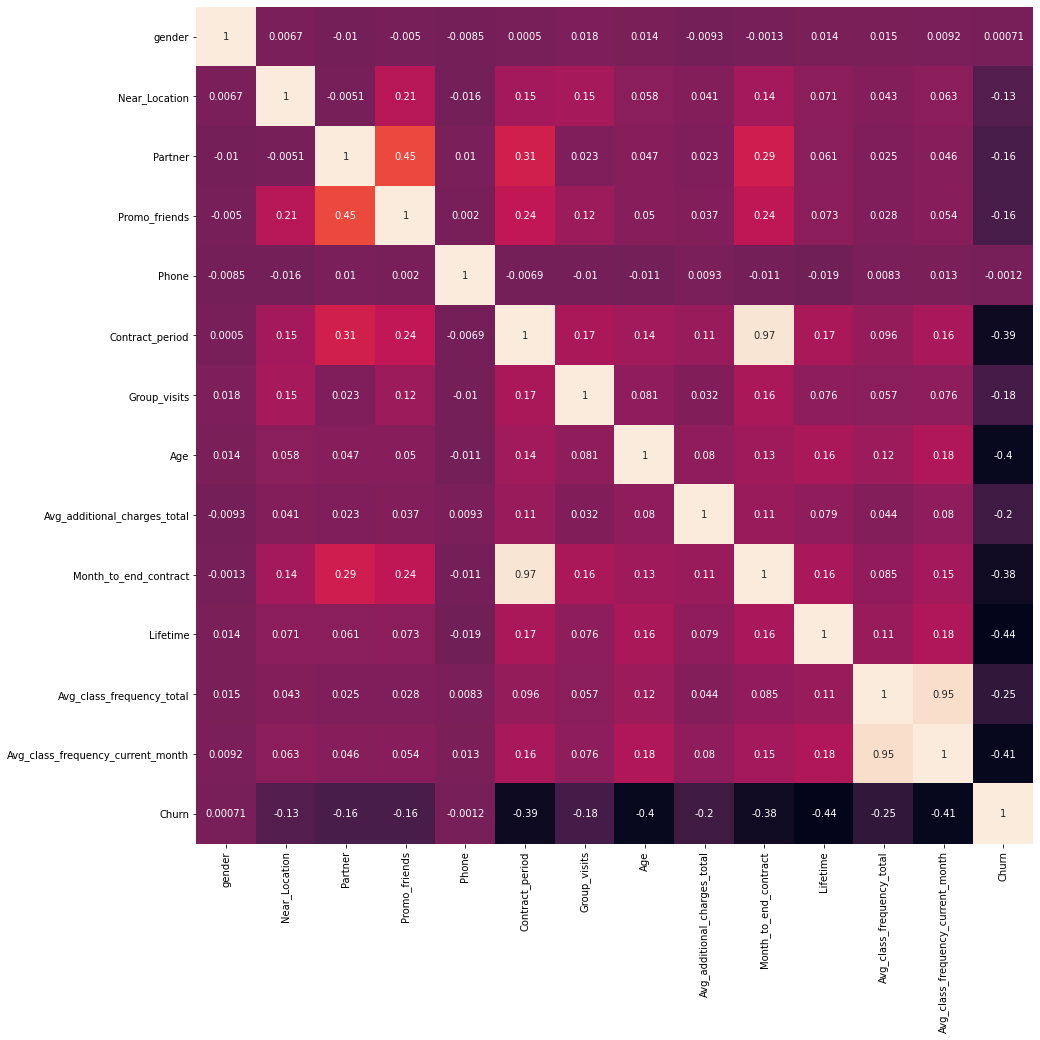

In [18]:
cm = gym_churn_us.corr()
fig = plt.figure(figsize=(15,35))
sns.heatmap(cm,annot=True,square=True,cbar=False)
plt.show()

Obviously, `Month_to_end_contract` and `Contract_period` corrolate. Current and latest weekly visits count also corrolate, even tough it was witnessed there are churned users who come less to the gym towards the end of the contract, in average.

# Model <a id="model"></a>

In [19]:
X = gym_churn_us.drop('Churn',axis=1)
y = gym_churn_us['Churn']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_val_st = scaler.transform(X_val)

lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st,y_train)
lr_predictions = lr_model.predict(X_val_st)
lr_probabilities = lr_model.predict_proba(X_val_st)[:,1]
print('Logistic Regression')
print('LR Accuracy: {:.2f}'.format(accuracy_score(y_val,lr_predictions)))
print('LR Precision: {:.2f}'.format(precision_score(y_val,lr_predictions)))
print('LR Recall: {:.2f}'.format(recall_score(y_val,lr_predictions)))
print('LR F1: {:.2f}'.format(f1_score(y_val,lr_predictions)))

threshold = 0.63
custom_predictions = [0 if i<threshold else 1 for i in lr_probabilities]# write your code here
print('\nCustom Logistic Regression')
print('Custom LR Accuracy: {:.2f}'.format(accuracy_score(y_val, custom_predictions)))
print('Custom LR Precision: {:.2f}'.format(precision_score(y_val, custom_predictions)))
print('Custom LR Recall: {:.2f}'.format(recall_score(y_val, custom_predictions)))
print('Custom LR F1: {:.2f}'.format(f1_score(y_val,custom_predictions)))

rf_model = RandomForestClassifier(random_state=0,min_samples_split=4)
rf_model.fit(X_train,y_train)
rf_predictions = rf_model.predict(X_val)
rf_probabilities = rf_model.predict_proba(X_val)[:,1]
print('\nRandom Forest Classifier')
print('RF Accuracy: {:.2f}'.format(accuracy_score(y_val,rf_predictions)))
print('RF Precision: {:.2f}'.format(precision_score(y_val,rf_predictions)))
print('RF Recall: {:.2f}'.format(recall_score(y_val,rf_predictions)))
print('RF F1: {:.2f}'.format(f1_score(y_val,rf_predictions)))

Logistic Regression
LR Accuracy: 0.92
LR Precision: 0.85
LR Recall: 0.83
LR F1: 0.84

Custom Logistic Regression
Custom LR Accuracy: 0.94
Custom LR Precision: 0.93
Custom LR Recall: 0.81
Custom LR F1: 0.87

Random Forest Classifier
RF Accuracy: 0.92
RF Precision: 0.85
RF Recall: 0.83
RF F1: 0.84


The custom Logistic Regression model gave better results, tough maybe the forest data can be better preprocessed (label encoding), so overall its a close margin between the two models.

**I removed 2 columns, one for each pair correlated, and got lower metrics for Logistic Regression. So in the end no columns are removed due to collinearity.**

# User Clusters <a id="uscl"></a>

## Dendrogram <a id="dend"></a>

In [20]:
# correlated columns are removed as well as the target

X = gym_churn_us.drop(['Churn','Avg_class_frequency_total'],axis=1)#,'Month_to_end_contract'],axis=1)

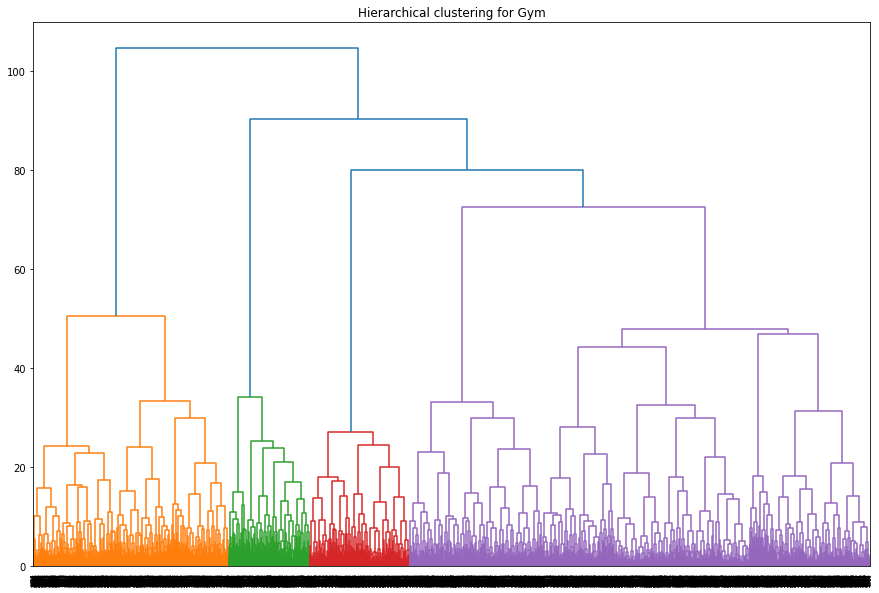

In [21]:
# obligatory standardization of data before passing it to the algorithm
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for Gym')
plt.show()

It seems there are 4-8 clusters. From the project description its known the ideal number of clusters is 5.

## Clustering <a id="clust"></a>

In [22]:
km = KMeans(n_clusters=5,random_state=0)
labels = km.fit_predict(X_sc)

X['cluster_km'] = labels

# get the statistics of the mean feature values per cluster
X.groupby('cluster_km').mean().sort_values('Age',ascending=False)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,
3,0.561346,0.998914,0.294245,0.212812,1.0,2.268187,0.552660,30.867535,172.123744,2.136808,5.320304,2.357235
1,0.505014,0.963537,0.786691,0.576117,1.0,10.599818,0.536919,29.846855,161.178224,9.667274,4.593437,2.021492
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.723967
0,0.502857,0.000000,0.464762,0.078095,1.0,2.428571,0.217143,28.580952,136.280017,2.272381,2.872381,1.567964
2,0.470588,1.000000,0.361345,0.230626,1.0,1.763772,0.253968,27.312792,116.923497,1.681606,1.802988,1.112031


Age, Lifetime, charges and weekly visits are ordered the same for all clusters, with group visits almost at the same order (only 21% of cluster 0 went to group visits, but this cluster consist of solely far-living users so it can be forgiven).
Clusters 3,1 and 4 consist of engaging users -

Cluster 3 at top, with a relatively low contract period average, together with the longest average lifetime. Perhaps it contains a big portion of users that already had their first contract expired.

Cluster 1 has the longest contract period by far.

Cluster 4 solely consist of no-phone users. Those people are good customers as well.

## Feature Distributions per Cluster <a id="fdpclu"></a>

In [23]:
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(df[x_name], df[y_name],
          hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

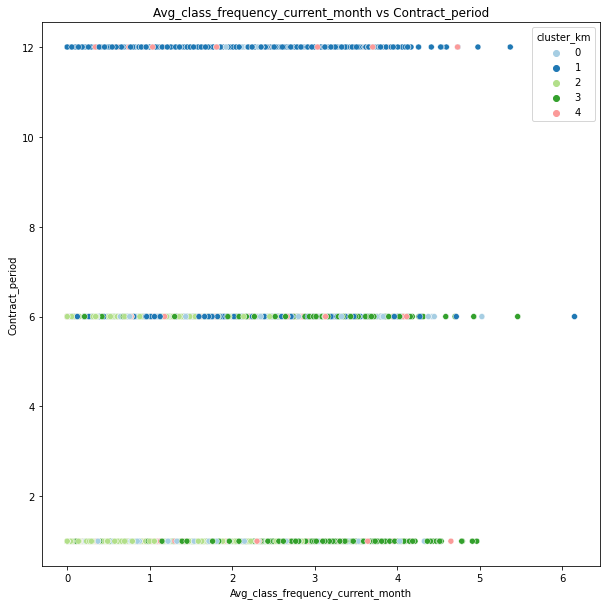

In [24]:
show_clusters_on_plot(X, 'Avg_class_frequency_current_month','Contract_period', 'cluster_km') 

Cluster 3 domains the right part of the shorter contracts, while cluster 1 domains the 1-year contract, for all frequencies.

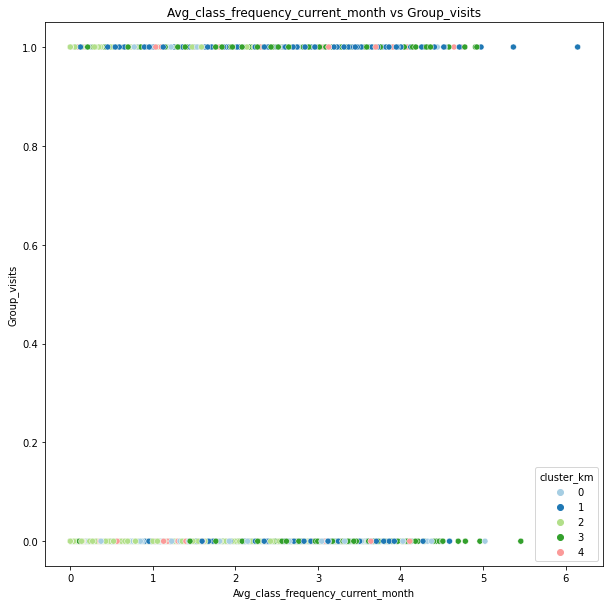

In [25]:
show_clusters_on_plot(X, 'Avg_class_frequency_current_month','Group_visits', 'cluster_km') 

The dominant clusters are more visible at the upper part.

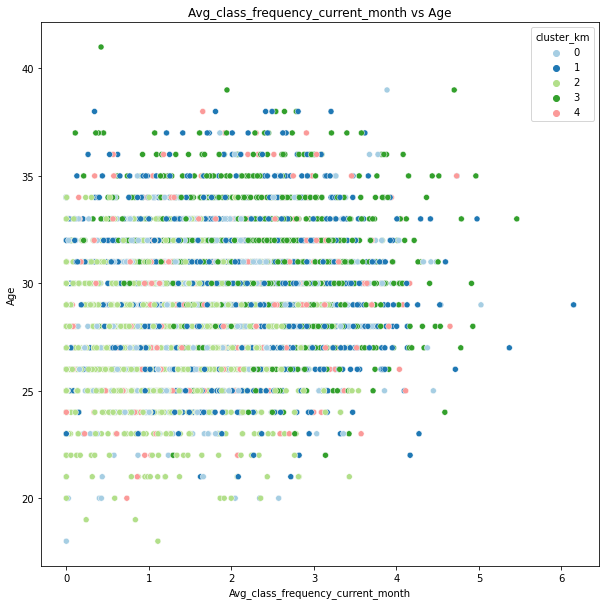

In [26]:
show_clusters_on_plot(X, 'Avg_class_frequency_current_month','Age', 'cluster_km') 

The strong clusters are older by 2-3 years.

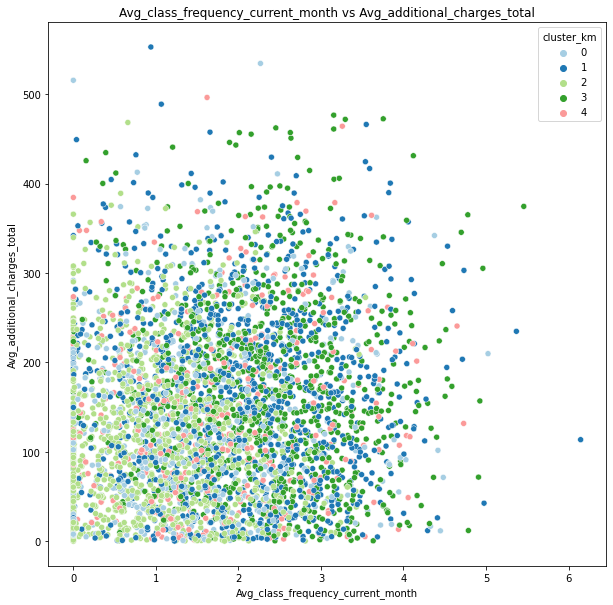

In [27]:
show_clusters_on_plot(X, 'Avg_class_frequency_current_month','Avg_additional_charges_total', 'cluster_km') 

Strong clusters (3,1,4) are frequent at top right side.

## Churn per Cluster <a id="cpc"></a>

In [28]:
gym_churn_us['cluster_km'] = labels
gym_churn_us.groupby('cluster_km')['Churn'].mean().sort_values()

cluster_km
1    0.028259
3    0.044517
4    0.266839
0    0.426667
2    0.618114
Name: Churn, dtype: float64

Clusters 1 and 3 are the best by far, churn-wise, with only 3% and 4% of churns per month. Cluster 3 had the better numbers in terms of engaging, but cluster 1 has a much longer contract, so that must affect things as well.
Cluster 4, altough consist of engaged users (in terms of charges, weekly visits and group visits), is much behind the top 2, with 27% churn per month.
For the bottom clusters, half the users quit every month.

# Conclusion <a id="conc"></a>

Good customers -

- Are living in proximity to the gym -<br>

<ul><b>Its worth advertising within the community, it would have much higher success rates in drawing customers to subscribe.</b></ul>

- Above 29 when signing up -<br>

<ul><b>A new Promo can be issued, for people in their 29-30. Something like one free month when you get 30. Sounds plausible.</b></ul>

- Visit the gym at least twice a week -<br>

<ul><b>Offer discounts for customers who complete 2 weeks streak (of at least 2 visits a week)</b></ul>


